In [2]:
# Importing dependencies
from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2DTranspose
from keras.layers import Conv2D

# Defining input image dimensions from MNIST dataset
img_rows = 28
img_cols = 28
channels = 1
img_shape = (img_rows, img_cols, channels)

# Asking user for type of NN for Generator network
# Discriminator network uses fully-connected MLP
type_NN = str(input("What type of Neural Network is of your choice for the Generator network? MLP or CNN?"))

##########################################################################
# Given input of noise (latent) vector, the Generator produces an image.
def build_generator(type_NN):

  # 1D array of size 100 (latent vector / noise)
  noise_shape = (100,)
  latent_dim = noise_shape

# Define your generator network
# Here we are only using Dense layers. But network can be complicated based
# on the application. For example, you can use VGG for super res. GAN.

  if type_NN == "MLP":
    print("Multilayer Perceptron (MLP) chosen for Generator network...")

    model = Sequential()

    model.add(Dense(256, input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Dense(1024))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))

    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)    #Generated image

    return Model(noise, img)

  elif type_NN == "CNN":

    print("Convolutional Neural Network (CNN) chosen for Generator network...")

    model = Sequential()

    # Start with a fully connected layer to project and reshape the noise
    model.add(Dense(128*7*7, input_shape=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((7, 7, 128)))

    # First transposed convolution layer
    model.add(Conv2DTranspose(128, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Second transposed convolution layer
    model.add(Conv2DTranspose(64, kernel_size=4, strides=2, padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # Output layer (e.g., a single-channel grayscale image or 3-channel color image)
    model.add(Conv2D(1, kernel_size=7, activation='tanh', padding='same'))

    noise = Input(shape=latent_dim)
    img = model(noise)

    return Model(noise, img)

# Alpha — α is a hyperparameter which controls the underlying value to which the
# function saturates negatives network inputs.
# Momentum — Tells the rate of training
##########################################################################

#Given an input image, the Discriminator outputs the likelihood of the image being real.
#Binary classification - true or false (we're calling it validity)

def build_discriminator():

    model = Sequential()

    model.add(Flatten(input_shape=img_shape))
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)

    #The validity is the Discriminator’s guess of input being real or not.
    validity = model(img)

    return Model(img, validity)

# Now that we have constructed our two models it’s time to pit them against each other.
# We do this by defining a training function, loading the data set, re-scaling our training
# images and setting the ground truths.
def train(epochs, batch_size=128, save_interval=50):

    # Load the dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Convert to float and Rescale -1 to 1 (Can also do 0 to 1)
    X_train = (X_train.astype(np.float32) - 127.5) / 127.5

    # Add channels dimension. As the input to our gen and discr. has a shape 28x28x1.
    X_train = np.expand_dims(X_train, axis=3)

    # Half of the images fed to Discriminator network is real
    half_batch = int(batch_size / 2)

    # We then loop through a number of epochs to train our Discriminator by first selecting
    # a random batch of images from our true dataset, generating a set of images from our
    # Generator, feeding both set of images into our Discriminator, and finally setting the
    # loss parameters for both the real and fake images, as well as the combined loss.

    for epoch in range(epochs):

        # Training the Discriminator
        # Select a random half batch of real images
        idx = np.random.randint(0, X_train.shape[0], half_batch)
        imgs = X_train[idx]

        # Creating noise (latent vector) for generating half batch of fake images
        noise = np.random.normal(0, 1, (half_batch, 100))

        # Generate a half batch of fake images
        gen_imgs = generator.predict(noise)

        # Train the discriminator on real and fake images, separately
        d_loss_real = discriminator.train_on_batch(imgs, np.ones((half_batch, 1)))
        d_loss_fake = discriminator.train_on_batch(gen_imgs, np.zeros((half_batch, 1)))

        # Take Discriminator loss as the average loss from real and fake images.
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Training the Generator
        # And within the same loop we train our Generator, by setting the input noise and
        # ultimately training the Generator to have the Discriminator label its samples as valid
        # by specifying the gradient loss.
        # Create noise vectors as input for generator.
        # Create as many noise vectors as defined by the batch size.
        # Based on normal distribution. Output will be of size (batch size, 100)
        noise = np.random.normal(0, 1, (batch_size, 100))

        # The generator wants the discriminator to label the generated samples as valid (ones)
        # This is where the generator is trying to trick discriminator into believing
        # the generated image is true (hence value of 1 for y)
        valid_y = np.array([1] * batch_size) #Creates an array of all ones of size=batch size

        # Generator is part of combined where it got directly linked with the discriminator
        # Train the generator with noise as x and 1 as y.
        # Again, 1 as the output as it is adversarial and if generator did a great
        # job of fooling the discriminator then the output would be 1 (true)
        g_loss = combined.train_on_batch(noise, valid_y)


        # Additionally, in order for us to keep track of our training process, we print the
        # progress and save the sample image output depending on the epoch interval specified.
        # Plot the progress

        print ("%d [D loss: %f, acc.: %.2f%%] [G loss: %f]" % (epoch, d_loss[0], 100*d_loss[1], g_loss))

        # If at save interval => save generated image samples
        if epoch % save_interval == 0:
            save_imgs(epoch)

# When the specific save_interval is hit, we call the save_imgs function
# This function saves our images for us to view
def save_imgs(epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, 100))
    gen_imgs = generator.predict(noise)

    # Rescale images 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r, c)
    cnt = 0
    for i in range(r):
        for j in range(c):
            axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
            axs[i,j].axis('off')
            cnt += 1
    fig.savefig("mnist_%d.png" % epoch)
    plt.close()

##############################################################################
# Defining an optimizer for easy use later on.
optimizer = Adam(0.0002, 0.5)  #Learning rate and momentum.

# Build and compile the discriminator first.
# Generator will be trained as part of the combined model, later.
# pick the loss function and the type of metric to keep track.
# Binary cross entropy as we are doing prediction and it is a better
# loss function compared to MSE or other.
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy'])

# Build and compile our generator, pick the loss function
# Since we are only generating (faking) images, let us not track any metrics.
generator = build_generator(type_NN = type_NN)
generator.compile(loss='binary_crossentropy', optimizer=optimizer)

# This defines the input noise for the generator.
# In a GAN the Generator network takes noise z as an input to produce its images.
z = Input(shape=(100,))   #Our random input to the generator
img = generator(z)

# This ensures that when we combine our networks we only train the Generator.
# While generator training we do not want discriminator weights to be adjusted.
# This doesn't affect the above descriminator training.
discriminator.trainable = False

# This specifies that our Discriminator will take the images generated by our Generator
# and true dataset and set its output to a parameter called valid, which will indicate
# whether the input is real or not.
valid = discriminator(img)  #Validity check on the generated image


# Here we combined the models and also set our loss function and optimizer.
# Again, we are only training the generator here.
# The ultimate goal here is for the Generator to fool the Discriminator.
# The combined model  (stacked generator and discriminator) takes
# noise as input => generates images => determines validity
combined = Model(z, valid)
combined.compile(loss='binary_crossentropy', optimizer=optimizer)

# epochs dictate the number of backward and forward propagations, the batch_size
# batch_size indicates the number of training samples per backward/forward propagation, and the
# save_interval specifies after how many epochs we call our save_image function.
train(epochs=100, batch_size=32, save_interval=10)

# Save model for future use to generate fake images
generator.save('generator_model.h5')

What type of Neural Network is of your choice for the Generator network? MLP or CNN?CNN


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)                  │ (None, 784)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 512)                 │         401,920 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 533,505 (2.04 MB)

 Trainable params: 533,505 (2.04 MB)

 Non-trainable params: 0 (0.00 B)

Convolutional Neural Network (CNN) chosen for Generator network...
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
0 [D loss: 0.780643, acc.: 35.94%] [G loss: 0.706144]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step
1 [D loss: 0.731649, acc.: 50.78%] [G loss: 0.694032]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step
2 [D loss: 0.742080, acc.: 40.10%] [G loss: 0.683521]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
3 [D loss: 0.757372, acc.: 32.65%] [G loss: 0.674202]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
4 [D loss: 0.758923, acc.: 31.01%] [G loss: 0.663681]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
5 [D loss: 0.777267, acc.: 26.68%] [G loss: 0.653367]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
6 [D loss: 0.776892, acc.: 25.96%] [G loss: 0.642812]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
7 [D loss: 0.782667, acc.: 25.03%] [G loss: 0.631461]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
8 [D loss: 0.787205, acc.: 24.66%] [G loss: 0.618643]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
9 [D loss: 0.799206, acc

99 [D loss: 1.731575, acc.: 19.42%] [G loss: 0.138155]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step


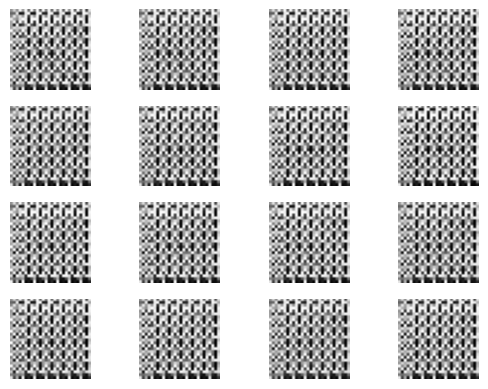

In [3]:
# Predicting using an already-trained model
# Uncomment to run this part of the code....
##############################################
# """

# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot as plt

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

# create and save a plot of generated images (reversed grayscale)
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		plt.subplot(n, n, 1 + i)
		# turn off axis
		plt.axis('off')
		# plot raw pixel data
		plt.imshow(examples[i, :, :, 0], cmap='gray_r')
	plt.show()

# load model
model = load_model('generator_model.h5')
# generate images
#Generate 16 images, each image provide a vector of size 100 as input
latent_points = generate_latent_points(100, 16)
# generate images
X = model.predict(latent_points)
# plot the result
save_plot(X, 4)  #Plot 4x4 grid (Change to 5 if generating 25 images)

#"""